### Context
Since its inception in 2008, Airbnb has disrupted the traditional hospitality industry as more travellers decide to use Airbnb as their primary means of accommodation. Airbnb offers travellers a more unique and personalized way of accommodation and experience.


## Task Details
As of October 2020, this data set contains nearly 226029 Airbnb listings in U.S. The purpose of this task is to predict the price of U.S. Airbnb rentals based on the data provided and any external dataset(s) with relevant information.

Expected Submission
Users should submit a CSV file with each listing from the data set and the model-predicted price :

id,  price <br>
49091, 83 <br>
50646, 81 <br>
56334, 69 <br>
...



In [1]:
from zipfile import ZipFile
import os

with ZipFile('us-airbnb-open-data.zip') as f :
    f.extractall(path ='Airbnb-data')
    
data_dir = 'Airbnb-data'
os.listdir(data_dir)

['AB_US_2020.csv']

In [2]:
csv_path = data_dir + '/AB_US_2020.csv'
csv_path

'Airbnb-data/AB_US_2020.csv'

In [3]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
pd.options.display.max_columns = 200
pd.options.display.max_rows = 200

data = pd.read_csv(csv_path)
data

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,city
0,38585,Charming Victorian home - twin beds + breakfast,165529,Evelyne,NaN,28804,35.651460,-82.627920,Private room,60,1,138,16/02/20,1.14,1,0,Asheville
1,80905,French Chic Loft,427027,Celeste,NaN,28801,35.597790,-82.555400,Entire home/apt,470,1,114,07/09/20,1.03,11,288,Asheville
2,108061,Walk to stores/parks/downtown. Fenced yard/Pet...,320564,Lisa,NaN,28801,35.606700,-82.555630,Entire home/apt,75,30,89,30/11/19,0.81,2,298,Asheville
3,155305,Cottage! BonPaul + Sharky's Hostel,746673,BonPaul,NaN,28806,35.578640,-82.595780,Entire home/apt,90,1,267,22/09/20,2.39,5,0,Asheville
4,160594,Historic Grove Park,769252,Elizabeth,NaN,28801,35.614420,-82.541270,Private room,125,30,58,19/10/15,0.52,1,0,Asheville
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226025,45506143,"DC Hidden In Plain ""Site""",25973146,Marci,NaN,"Downtown, Chinatown, Penn Quarters, Mount Vern...",38.903880,-77.029730,Entire home/apt,104,1,0,NaN,NaN,2,99,Washington D.C.
226026,45511428,DC 3 BR w/ screen porch 3 blck to metro w/ par...,231133074,Thomas,NaN,"Brookland, Brentwood, Langdon",38.920820,-76.990980,Entire home/apt,151,2,0,NaN,NaN,1,300,Washington D.C.
226027,45514685,Charming Penthouse Apt w/ Rooftop Terrace in L...,33758935,Bassem,NaN,"Shaw, Logan Circle",38.911170,-77.033540,Entire home/apt,240,2,0,NaN,NaN,1,173,Washington D.C.
226028,45516412,Adams Morgan/Nat'l Zoo 1 BR Apt #32,23193071,Michael,NaN,"Kalorama Heights, Adams Morgan, Lanier Heights",38.926630,-77.044360,Entire home/apt,60,21,0,NaN,NaN,5,362,Washington D.C.


In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 13, 10

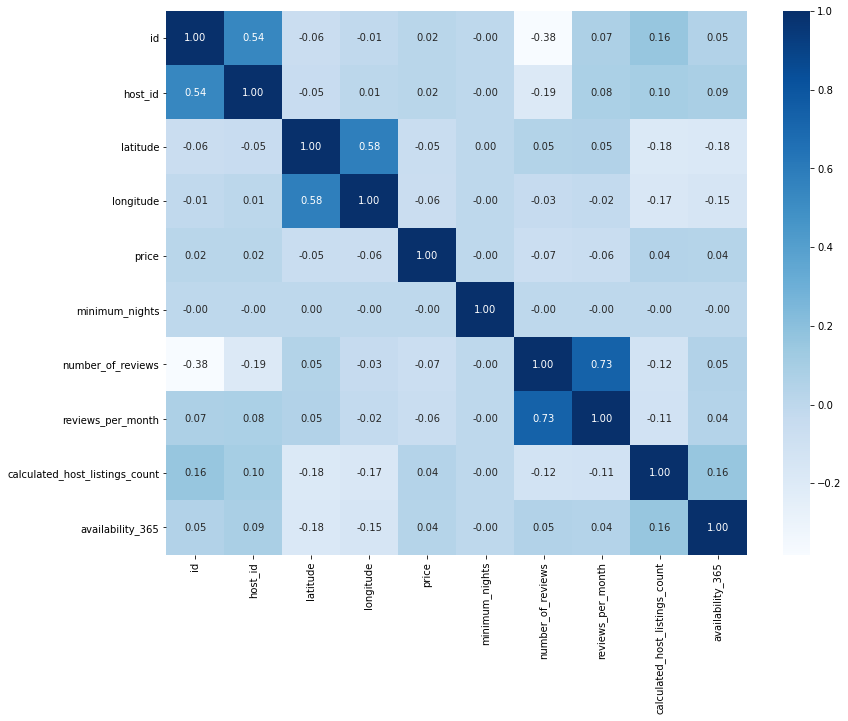

In [5]:
sns.heatmap(data.corr(), annot = True, fmt = ".2f", cmap = 'Blues');

In [6]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split as tts
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
import numpy as np


# train & target :
X = data.drop('price', axis = 1)
y = data['price']

# split the data first :
X_train, X_valid, y_train, y_valid = tts(X, y, test_size=0.25,
                                         random_state = 42)


#1. identify numerical and categorical cols :
numerical_cols = [cname for cname in X.columns if 
                X[cname].dtype in ['int64', 'float64']]

categorical_cols = [cname for cname in X.columns if
                    X[cname].nunique() < 50 and 
                    X[cname].dtype in ['object', 'bool']]


#2. set up pipelines to transform numerical & categorical data :
# Also pipelines are valuable for cleaning up machine learning code and avoiding errors, 
# and are especially useful for workflows with sophisticated data preprocessing. 

numerical_transformer = SimpleImputer(strategy='constant')

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy = 'most_frequent')),
    ('onehot', OneHotEncoder(sparse = False, handle_unknown = 'ignore'))
])


#3. Tranforming columns both numeric & categorical :
preprocessor = ColumnTransformer(transformers = [
    ('num',  numerical_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)
])


#4. Import model and set up Hyperparameteres : 
model = XGBRegressor(base_score = 0.5, booster = 'gbtree', colsample_bylevel = 1,
                     colsample_bynode = 1, colsample_bytree = 0.6, gamma = 0.0, gpu_id = -1,
                     importance_type = 'gain', interaction_constraints = '',
                     learning_rate = 0.02, max_delta_step = 0, max_depth = 4,
                     min_child_weight = 0.0, n_estimators = 1250, n_jobs = 0, 
                     num_parallel_tree = 1, random_state = 0,
                     reg_alpha = 0, reg_lambda = 1, scale_pos_weight = 1, subsample=0.8,
                     tree_method = 'exact', validate_parameters = 1, verbosity=None )
# These hyperparameters are found after performing GridSearchCV
# Not mentioning the process here, since its was too lengthy.


#5. Putting it together
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model)
                     ])

clf.fit(X_train, y_train, model__verbose=False) 
preds = clf.predict(X_valid)


print('RMSE:', mean_squared_error(y_valid, preds, squared = False))

RMSE: 481.6024563433477


In [7]:
preds = clf.predict(X)
op = pd.DataFrame({'id':X.id,
                  'Price':preds})

op.to_csv('submission.csv', index = False)